# Code for paper _Sheep weight estimation using 3D images_

## Library imports

In [1]:
import pandas as pd
import os 
import glob
from tqdm.auto import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(2019)

## Data loading

In [2]:
D = pd.read_csv(os.path.join('..', 'data', 'id_weight_sex_uuid_area.csv'), usecols=['id', 'sex','area', 'weight', 'uuid'])
D = D.reindex(columns=['id', 'sex','area', 'weight', 'uuid'])
print(f'D.shape: {D.shape}')
D.head()

D.shape: (2069, 5)


,id,sex,area,weight,uuid
0,0268,1,316766.459982,24.5,3b144fdfdb9f4e02b0f65aed674fbd72
1,0261,1,339995.243532,27.1,960fd92c91f541f6b85889426c39a0fe
2,0236,0,328920.945876,25.5,ca10f050724d47f5971c3530ef341a8d
3,0236,0,331309.336892,25.5,3c4dcc3c6d83425dab0d0acd75227f99
4,0238,1,340636.324958,25.8,46d3f67bbf684992ac945ce7c1991ae7


Sex has been coded as  1: 'Female', 0: 'Male'

## Duplicates removal

In [3]:
D = D[~D.duplicated(subset=['area', 'weight'])]
D.shape

(828, 5)

In [4]:
ids = D.id.unique()
len(ids)

54

The dataset comprises 54 sheeps

## Training set and test set splitting

In [5]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

ids_train, ids_test = train_test_split(D.id.unique(), shuffle=True, random_state=2019, test_size=0.4)
print(f'Training set:{ids_train.shape[0]} \t Test set:{ids_test.shape[0]}')

D_train = D.query('id in @ids_train')
D_train.to_csv('D_train.csv')
D_test = D.query('id in @ids_test')
D_test.to_csv('D_test.csv')

Training set:32 	 Test set:22


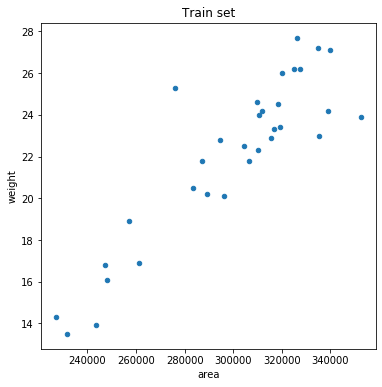

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.title('Train set')
D_train.groupby('id').mean().plot(kind='scatter', x='area', y='weight', ax=ax);
#fig.savefig('area_vs_weight.pdf')

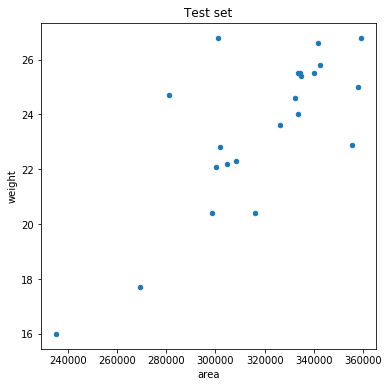

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.title('Test set')
D_test.groupby('id').mean().plot(kind='scatter', x='area', y='weight', ax=ax);

In [8]:
X_train, y_train = D_train.groupby('id').mean().loc[:, ['area', 'sex']], D_train.groupby('id').mean().loc[:, ['weight']] 
X_test, y_test = D_test.groupby('id').mean().loc[:, ['area', 'sex']], D_test.groupby('id').mean().loc[:, ['weight']] 

## Pipegraph system definition

In [9]:
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import learning_curve

from pipegraph.base import PipeGraph, RegressorsWithDataDependentNumberOfReplicas, ColumnSelector, NeutralRegressor

In [10]:
selector = ColumnSelector(mapping={'X': slice(0, 1),
                                   'sex': slice(1,2)})
poly = PolynomialFeatures(degree=30)

scaler = MinMaxScaler()

models = RegressorsWithDataDependentNumberOfReplicas(steps=[('regressor', LinearRegression() )])

neutral =  NeutralRegressor()

steps = [('selector', selector),
         ('poly', poly),
         ('scaler', scaler),
         ('models', models),
         ('neutral', neutral)]

connections = {'selector': {'X': 'X'},
               
               'poly': {'X': ('selector', 'X')},
            
               'scaler': {'X': 'poly'},
            
               'models': {'X': 'scaler',
                          'y': 'y',
                          'selection': ('selector', 'sex')},
               'neutral': {'X': 'models',
                           'y': 'y'},
               }
pgraph = PipeGraph(steps=steps, fit_connections=connections)


# ```param_grid```  definition for GridSearchCV

In [11]:

linear_reg  = RegressorsWithDataDependentNumberOfReplicas( steps=[('regressor', LinearRegression() )])
lasso_reg   = RegressorsWithDataDependentNumberOfReplicas( steps=[('regressor', Lasso()      )])
ridge_reg   = RegressorsWithDataDependentNumberOfReplicas( steps=[('regressor', Ridge()      )])
elastic_reg = RegressorsWithDataDependentNumberOfReplicas( steps=[('regressor', ElasticNet() )])
svr_reg     = RegressorsWithDataDependentNumberOfReplicas( steps=[('regressor', SVR() )])
rf_reg      = RegressorsWithDataDependentNumberOfReplicas( steps=[('regressor', RandomForestRegressor() )])
adaboost_reg = RegressorsWithDataDependentNumberOfReplicas( steps=[('regressor', AdaBoostRegressor() )])
extratrees_reg = RegressorsWithDataDependentNumberOfReplicas( steps=[('regressor', ExtraTreesRegressor() )])


linear_grid = {'models': [linear_reg],
               'models__regressor__fit_intercept': [True, False],
               'models__regressor__normalize': [True, False],
               'poly__degree': range(1,5), 
               }

lasso_grid = {'models': [lasso_reg],
              'models__regressor__fit_intercept': [True, False],
              'models__regressor__normalize': [True, False],
              'models__regressor__alpha': np.linspace(0.5, 5, num=10), 
              'poly__degree': range(1,5),
             }

ridge_grid = {'models': [ridge_reg],
              'models__regressor__fit_intercept': [True, False],
              'models__regressor__normalize': [True, False],
              'models__regressor__alpha': np.linspace(0.5, 5, num=10), 
              'poly__degree': range(1,5),
             }

elastic_grid = {'models': [elastic_reg],
                'models__regressor__fit_intercept': [True, False],
                'models__regressor__normalize': [True, False],
                'models__regressor__alpha': np.linspace(0.5, 5, num=10), 
                'models__regressor__l1_ratio': np.linspace(0, 1, num=10), 
            
               'poly__degree': range(1,5), 
               }

svr_grid = {'models': [svr_reg],
            'models__regressor__kernel': ['rbf', 'poly', 'sigmoid'],
            'models__regressor__degree': range(1,5),
            'models__regressor__gamma': ['auto', 'scale'],
            'models__regressor__C': np.linspace(0.5,5, num=10),
            'models__regressor__shrinking': [True, False],
            'poly__degree': range(1,5) 
}

rf_grid = {'models': [rf_reg],
           'models__regressor__n_estimators': range(5,20),
           'poly__degree': range(1,5) ,
          }

adaboost_grid = {'models': [adaboost_reg],
                 'models__regressor__n_estimators': range(5,20),
                 'poly__degree': range(1,5) ,
                }

extratrees_grid = {'models': [extratrees_reg],
                   'models__regressor__n_estimators': range(5,20),
                   'poly__degree': range(1,5) ,
                   }

param_grid = [linear_grid, 
              lasso_grid,
              ridge_grid, 
              elastic_grid, 
              svr_grid,
              rf_grid,
              adaboost_grid,
              extratrees_grid
             ]

cv_value = 3 
print(f'Number of models: {cv_value* len(ParameterGrid(param_grid))}')

Number of models: 12108


## GridSearchCV hyperparameter tuning

In [12]:
import warnings
import sklearn

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=sklearn.exceptions.ConvergenceWarning)
    warnings.filterwarnings("ignore",category=sklearn.exceptions.DataConversionWarning)
    gs = GridSearchCV(estimator=pgraph,
                      param_grid=param_grid, 
                      cv=cv_value,
                      refit=True, 
                      scoring='neg_mean_squared_error',
                      n_jobs=-1,
                      verbose=10)
    gs.fit(X_train, y_train)

Fitting 3 folds for each of 4036 candidates, totalling 12108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1789s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1427s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 161 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 221 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    3.9s
[Parallel(n_jo

## Best model

In [13]:
gs.best_estimator_

best_estimator = gs.best_estimator_
print('Mejor:', best_estimator.named_steps.models.named_steps.regressor)


Mejor: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)


#### Male coeficcients

In [14]:
best_estimator.named_steps.models._pipegraph.named_steps.regressorsBundle.named_steps.regressor_0.coef_


array([[ 0.        , 13.59276031]])

#### Female coefficients

In [15]:
best_estimator.named_steps.models._pipegraph.named_steps.regressorsBundle.named_steps.regressor_1.coef_

array([[ 0.        , 13.20813176]])

## Results table

In [16]:
results = pd.DataFrame(gs.cv_results_)
results['models'] = pd.DataFrame.from_records(results.params)['models'].apply(lambda x: str(x.named_steps.regressor))
results.params[0]['models'].named_steps.regressor

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [17]:
best_results_per_model_type = pd.pivot_table(data=results,
                                             index='models',
                                             values = ['mean_test_score'],
                                             aggfunc='max')

print('Cross Validation mean errors')
best_results_per_model_type.sort_values(by='mean_test_score', ascending=False, inplace=True)
(best_results_per_model_type*100).round(1)

Cross Validation mean errors


,mean_test_score
models,
"LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)",-931.4
"Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,\n normalize=False, random_state=None, solver='auto', tol=0.001)",-1091.6
"AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',\n n_estimators=50, random_state=None)",-1118.6
"RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,\n max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, n_estimators='warn',\n n_jobs=None, oob_score=False, random_state=None,\n verbose=0, warm_start=False)",-1259.7
"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,\n gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,\n tol=0.001, verbose=False)",-1517.9
"ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,\n max_iter=1000, normalize=False, positive=False, precompute=False,\n random_state=None, selection='cyclic', tol=0.0001, warm_start=False)",-1532.6
"ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,\n max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, n_estimators='warn',\n n_jobs=None, oob_score=False, random_state=None, verbose=0,\n warm_start=False)",-1798.0
"Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,\n normalize=False, positive=False, precompute=False, random_state=None,\n selection='cyclic', tol=0.0001, warm_start=False)",-1932.5


## Plots: Actual vs. Predicted values

In [18]:
y_train_pred = gs.predict(X_train)
y_test_pred = gs.predict(X_test)

Text(0.5, 1.0, 'Weight vs. Area')

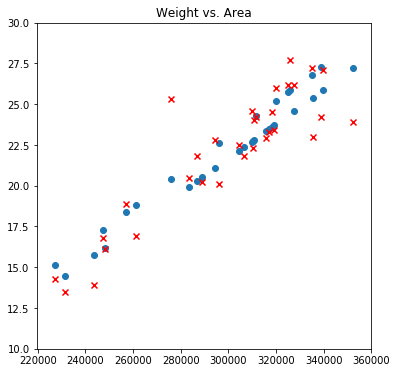

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))
#ax.set_xlim(10,30)
ax.set_ylim(10,30)
plt.scatter(X_train.area, y_train_pred)
plt.scatter(X_train.area, y_train.weight, c='r', marker='x');
plt.title('Weight vs. Area')

Text(0.5, 1.0, 'y Actual vs. y Predicted: Train dataset')

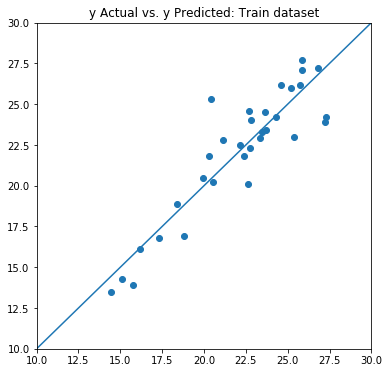

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(10,30)
ax.set_ylim(10,30)
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.scatter(y_train_pred, y_train)
plt.title('y Actual vs. y Predicted: Train dataset')


Text(0.5, 1.0, 'Residuals: Train dataset')

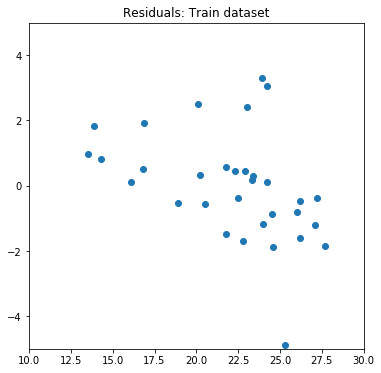

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(10,30)
ax.set_ylim(-5,5)
plt.scatter(y_train,  y_train_pred.values -y_train.values);
plt.title('Residuals: Train dataset')

## Error summary

In [26]:
print(f'MAE train: {round(mean_absolute_error(y_true=y_train, y_pred=y_train_pred), 2)}')
print(f'MAE test: {round(mean_absolute_error(y_true=y_test, y_pred=y_test_pred), 2)}')
print(f'MSE train: {round(mean_squared_error(y_true=y_train, y_pred=y_train_pred), 2)}')
print(f'MSE test: {round(mean_squared_error(y_true=y_test, y_pred=y_test_pred), 2)}')

MAE train: 1.24
MAE test: 1.73
MSE train: 2.7
MSE test: 4.88


## Learning curves

In [27]:
from sklearn.model_selection import ShuffleSplit

# The code for this function comes from Aurelien Geron's book:
# 'Hands-on machine learning with Scikit-Learn and Tensorflow'

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring=None):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

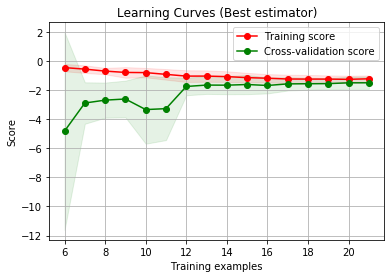

In [28]:

title = "Learning Curves (Best estimator)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv =ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

dibu = plot_learning_curve(best_estimator,
                    title,
                    X_train,
                    y_train,
                    train_sizes=range(6, 22),
                    cv=cv,
                    n_jobs=-1,
                    
                    scoring='neg_mean_absolute_error');
#dibu.savefig("learning_curve.pdf")